In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
import statsmodels.api as sm
#import mplcursors
from pylab import rcParams
from matplotlib.backends.backend_agg import FigureCanvasAgg
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from math import sqrt
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier


plt.style.use('seaborn-darkgrid')

In [2]:
COVIDAGI = pd.read_csv('COVIDAGI.csv',index_col = 0)
COVIDAGI

,State,cases,deaths,AGI Total,AGI Top 1 Percent,AGI Top 5 Percent,AGI Top 10 Percent,AGI Top 25 Percent,AGI Top 50 Percent,AGI Top 75 Percent
0,Alabama,387786,14345,119662909,18553159,35924229,49537638,76667112,101687773,114405941
1,Alaska,18316,367,23969001,2848087,6184956,8915998,14554105,20064361,22927860
2,Arizona,426614,18857,197753744,33609317,63073164,85351788,128616004,168531690,189378565
3,Arkansas,161569,3301,74634888,16319991,26475276,34256878,49689104,64088761,71584342
4,California,2664110,102387,1549284943,356240355,600859502,772738760,1086299917,1360947743,1497300869
5,Colorado,766512,37828,212581123,37479649,69617571,93359185,138935934,181679584,204043171
6,Connecticut,1314995,104185,175792834,47379889,74456114,92142733,125039874,155284852,170426876
7,Delaware,234327,7813,31403165,4412370,8899481,12464894,19652753,26529258,30056514
8,District of Columbia,229466,10822,34743188,7442186,13245281,17240750,24153683,30301657,33570901
9,Florida,1726811,63147,750608252,213461301,325886670,401558825,540976844,663846145,726074247


In [6]:
COVIDAGI.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51 entries, 0 to 50
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   State               51 non-null     object
 1   cases               51 non-null     int64 
 2   deaths              51 non-null     int64 
 3   AGI Total           51 non-null     int64 
 4   AGI Top 1 Percent   51 non-null     int64 
 5   AGI Top 5 Percent   51 non-null     int64 
 6   AGI Top 10 Percent  51 non-null     int64 
 7   AGI Top 25 Percent  51 non-null     int64 
 8   AGI Top 50 Percent  51 non-null     int64 
 9   AGI Top 75 Percent  51 non-null     int64 
dtypes: int64(9), object(1)
memory usage: 4.4+ KB


In [7]:
COVIDAGI.isnull().sum()

State                 0
cases                 0
deaths                0
AGI Total             0
AGI Top 1 Percent     0
AGI Top 5 Percent     0
AGI Top 10 Percent    0
AGI Top 25 Percent    0
AGI Top 50 Percent    0
AGI Top 75 Percent    0
dtype: int64

In [8]:
COVIDAGI.describe()

,cases,deaths,AGI Total,AGI Top 1 Percent,AGI Top 5 Percent,AGI Top 10 Percent,AGI Top 25 Percent,AGI Top 50 Percent,AGI Top 75 Percent
count,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01,5.100000e+01
mean,1.056306e+06,5.861198e+04,2.173379e+08,4.397083e+07,7.653212e+07,1.002433e+08,1.457253e+08,1.877254e+08,2.091911e+08
std,2.249183e+06,1.579360e+05,2.771243e+08,6.822804e+07,1.107285e+08,1.404116e+08,1.951457e+08,2.436947e+08,2.679196e+08
min,1.831600e+04,2.810000e+02,2.048172e+07,2.848087e+06,5.883104e+06,8.166850e+06,1.278072e+07,1.723822e+07,1.963047e+07
25%,1.696980e+05,4.021000e+03,4.810599e+07,7.242758e+06,1.398235e+07,1.946382e+07,3.039541e+07,4.071721e+07,4.609241e+07
50%,3.877860e+05,1.425100e+04,1.196629e+08,2.054118e+07,3.733305e+07,4.986673e+07,7.666711e+07,1.016878e+08,1.144059e+08
75%,1.047118e+06,5.046050e+04,2.944865e+08,4.816363e+07,9.222678e+07,1.256728e+08,1.912240e+08,2.516520e+08,2.825032e+08
max,1.504181e+07,1.081194e+06,1.549285e+09,3.562404e+08,6.008595e+08,7.727388e+08,1.086300e+09,1.360948e+09,1.497301e+09


In [9]:
corr = COVIDAGI.corr()
corr

,cases,deaths,AGI Total,AGI Top 1 Percent,AGI Top 5 Percent,AGI Top 10 Percent,AGI Top 25 Percent,AGI Top 50 Percent,AGI Top 75 Percent
cases,1.000000,0.990033,0.554417,0.620500,0.592615,0.579523,0.565563,0.559362,0.556316
deaths,0.990033,1.000000,0.464698,0.540796,0.508158,0.493196,0.477309,0.470197,0.466780
AGI Total,0.554417,0.464698,1.000000,0.982446,0.993602,0.996809,0.999215,0.999895,0.999992
AGI Top 1 Percent,0.620500,0.540796,0.982446,1.000000,0.997090,0.993901,0.988657,0.984805,0.983069
AGI Top 5 Percent,0.592615,0.508158,0.993602,0.997090,1.000000,0.999411,0.997181,0.995043,0.993986
AGI Top 10 Percent,0.579523,0.493196,0.996809,0.993901,0.999411,1.000000,0.999158,0.997820,0.997082
AGI Top 25 Percent,0.565563,0.477309,0.999215,0.988657,0.997181,0.999158,1.000000,0.999676,0.999349
AGI Top 50 Percent,0.559362,0.470197,0.999895,0.984805,0.995043,0.997820,0.999676,1.000000,0.999942
AGI Top 75 Percent,0.556316,0.466780,0.999992,0.983069,0.993986,0.997082,0.999349,0.999942,1.000000


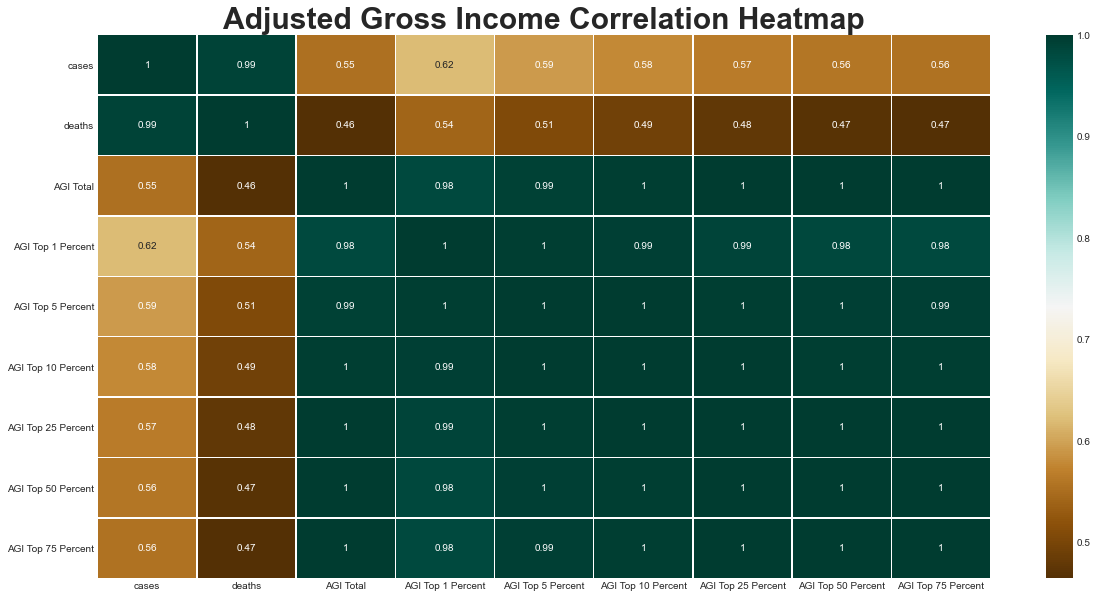

In [10]:
plt.figure(figsize = (20,10))
sns.heatmap(corr, cmap = 'BrBG', annot = True, linewidths = 0.5)
plt.title('Adjusted Gross Income Correlation Heatmap', fontweight = 'bold', fontsize = 30);

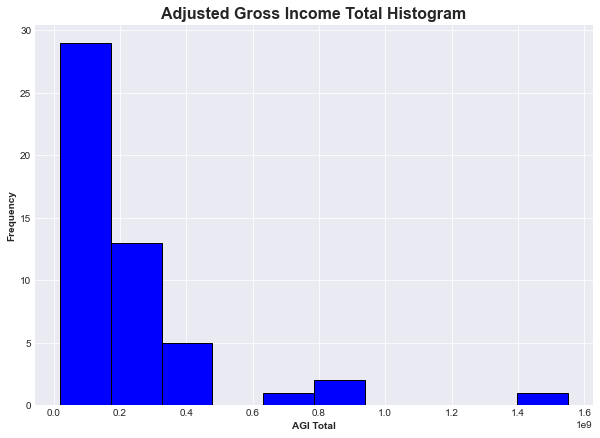

In [11]:
plt.style.use('seaborn-darkgrid')

COVIDAGI['AGI Total'].plot(kind = 'hist', color = 'blue', edgecolor = 'black', figsize = (10,7))
plt.title('Adjusted Gross Income Total Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('AGI Total', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

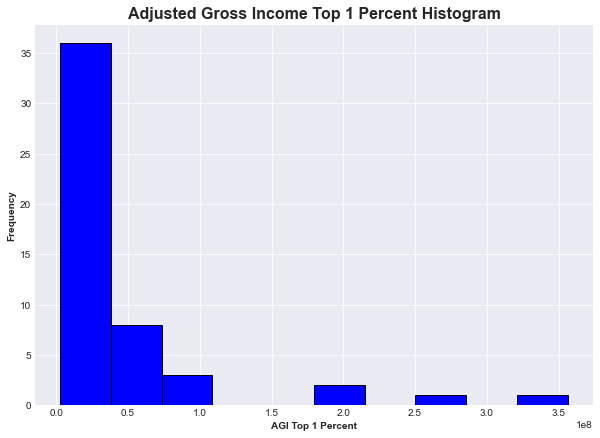

In [12]:
plt.style.use('seaborn-darkgrid')

COVIDAGI['AGI Top 1 Percent'].plot(kind = 'hist', color = 'blue', edgecolor = 'black', figsize = (10,7))
plt.title('Adjusted Gross Income Top 1 Percent Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('AGI Top 1 Percent', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

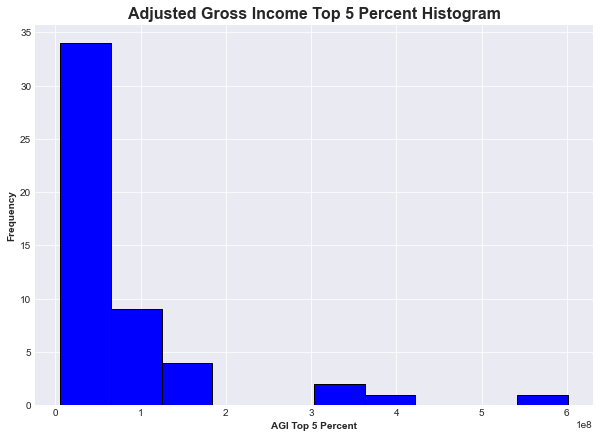

In [13]:
plt.style.use('seaborn-darkgrid')

COVIDAGI['AGI Top 5 Percent'].plot(kind = 'hist', color = 'blue', edgecolor = 'black', figsize = (10,7))
plt.title('Adjusted Gross Income Top 5 Percent Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('AGI Top 5 Percent', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

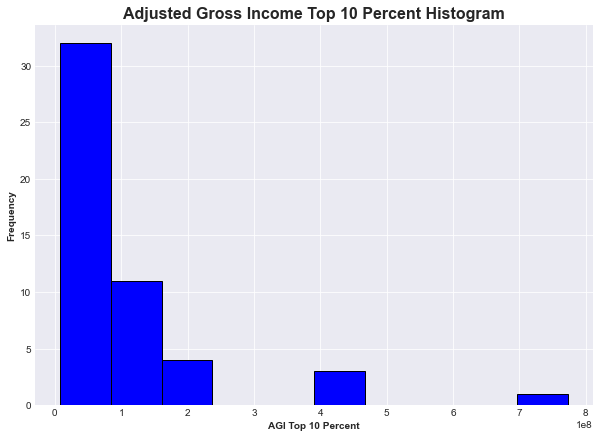

In [14]:
plt.style.use('seaborn-darkgrid')

COVIDAGI['AGI Top 10 Percent'].plot(kind = 'hist', color = 'blue', edgecolor = 'black', figsize = (10,7))
plt.title('Adjusted Gross Income Top 10 Percent Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('AGI Top 10 Percent', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

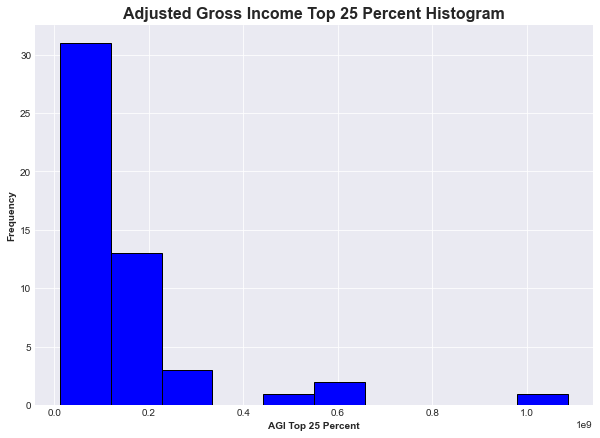

In [15]:
plt.style.use('seaborn-darkgrid')

COVIDAGI['AGI Top 25 Percent'].plot(kind = 'hist', color = 'blue', edgecolor = 'black', figsize = (10,7))
plt.title('Adjusted Gross Income Top 25 Percent Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('AGI Top 25 Percent', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

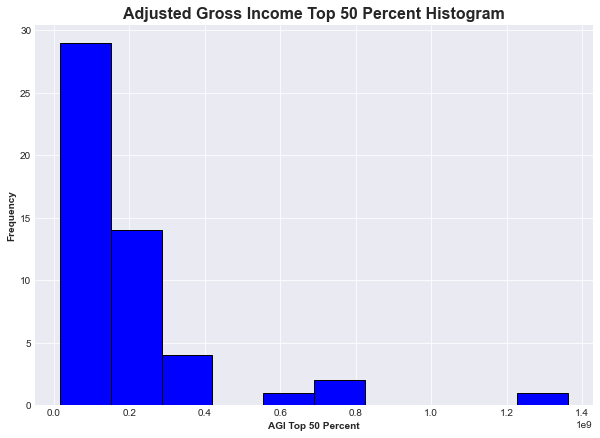

In [16]:
plt.style.use('seaborn-darkgrid')

COVIDAGI['AGI Top 50 Percent'].plot(kind = 'hist', color = 'blue', edgecolor = 'black', figsize = (10,7))
plt.title('Adjusted Gross Income Top 50 Percent Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('AGI Top 50 Percent', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

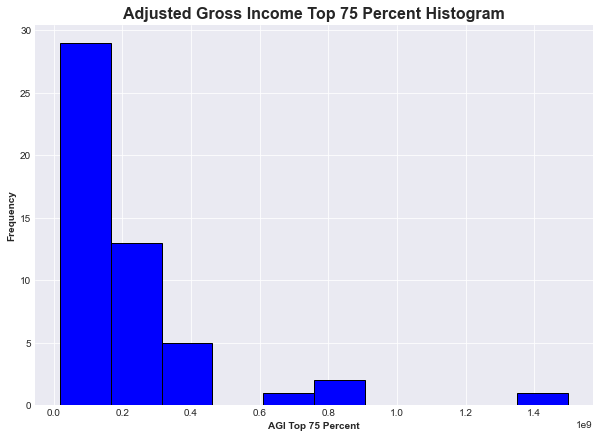

In [17]:
plt.style.use('seaborn-darkgrid')

COVIDAGI['AGI Top 75 Percent'].plot(kind = 'hist', color = 'blue', edgecolor = 'black', figsize = (10,7))
plt.title('Adjusted Gross Income Top 75 Percent Histogram', fontsize = 16, fontweight = 'bold')
plt.xlabel('AGI Top 75 Percent', fontsize = 10, fontweight = 'bold')
plt.ylabel('Frequency', fontsize = 10, fontweight = 'bold');

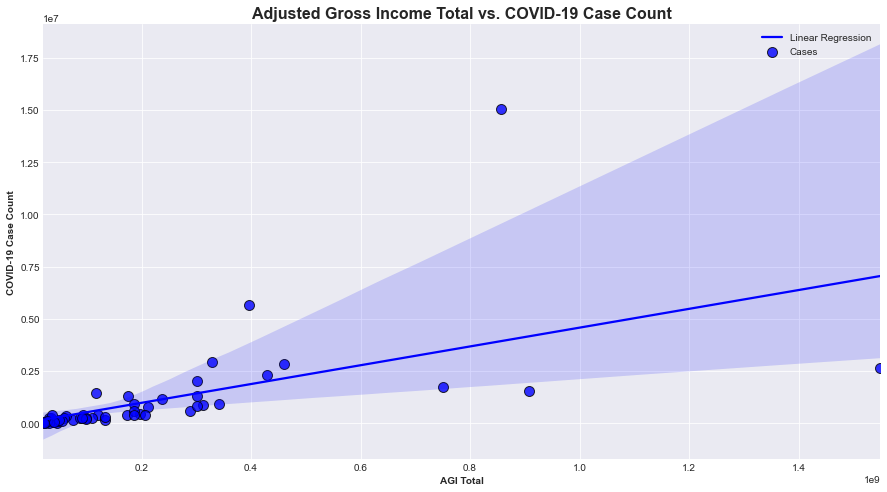

In [18]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'AGI Total', y = 'cases', data = COVIDAGI, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Adjusted Gross Income Total vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('AGI Total', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [19]:
model1 = sm.OLS(COVIDAGI['cases'], COVIDAGI['AGI Total']).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.434
Model:                            OLS   Adj. R-squared (uncentered):              0.423
Method:                 Least Squares   F-statistic:                              38.33
Date:                Wed, 10 Jun 2020   Prob (F-statistic):                    1.10e-07
Time:                        00:26:48   Log-Likelihood:                         -808.45
No. Observations:                  51   AIC:                                      1619.
Df Residuals:                      50   BIC:                                      1621.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
AGI Total      0.0046      0.001      6.191      0.000       0.003       0.006
==============================================================================
Omnibus:                       77.470   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1224.090
Skew:                           3.917   Prob(JB):                    1.56e-266
Kurtosis:                      25.686   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

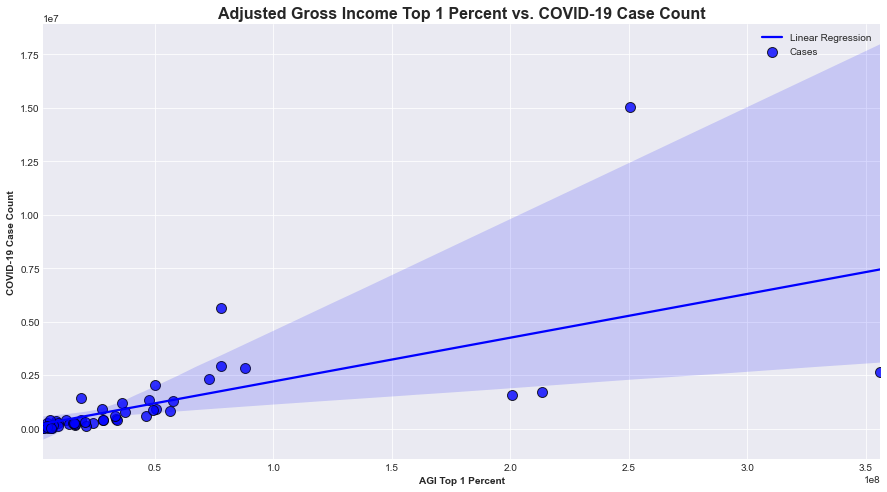

In [20]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'AGI Top 1 Percent', y = 'cases', data = COVIDAGI, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Adjusted Gross Income Top 1 Percent vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('AGI Top 1 Percent', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [21]:
model2 = sm.OLS(COVIDAGI['cases'], COVIDAGI['AGI Top 1 Percent']).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.495
Model:                            OLS   Adj. R-squared (uncentered):              0.485
Method:                 Least Squares   F-statistic:                              49.03
Date:                Wed, 10 Jun 2020   Prob (F-statistic):                    5.95e-09
Time:                        00:26:48   Log-Likelihood:                         -805.54
No. Observations:                  51   AIC:                                      1613.
Df Residuals:                      50   BIC:                                      1615.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
AGI Top 1 Percent     0.0215      0.003      7.002      0.000       0.015       0.028
==============================================================================
Omnibus:                       59.744   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              653.043
Skew:                           2.741   Prob(JB):                    1.56e-142
Kurtosis:                      19.651   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

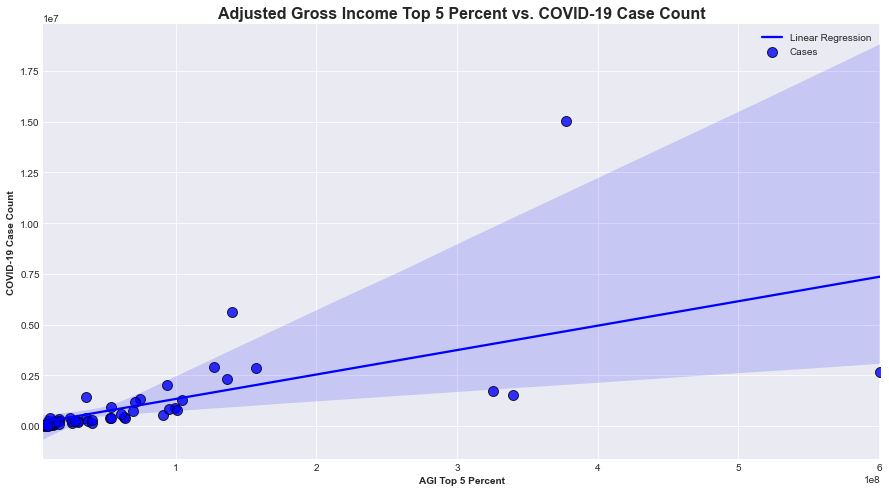

In [22]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'AGI Top 5 Percent', y = 'cases', data = COVIDAGI, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Adjusted Gross Income Top 5 Percent vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('AGI Top 5 Percent', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [23]:
model3 = sm.OLS(COVIDAGI['cases'], COVIDAGI['AGI Top 5 Percent']).fit()
model3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.468
Model:                            OLS   Adj. R-squared (uncentered):              0.458
Method:                 Least Squares   F-statistic:                              44.04
Date:                Wed, 10 Jun 2020   Prob (F-statistic):                    2.22e-08
Time:                        00:26:48   Log-Likelihood:                         -806.86
No. Observations:                  51   AIC:                                      1616.
Df Residuals:                      50   BIC:                                      1618.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
AGI Top 5 Percent     0.0126      0.002      6.637      0.000       0.009       0.016
==============================================================================
Omnibus:                       67.511   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              869.257
Skew:                           3.229   Prob(JB):                    1.75e-189
Kurtosis:                      22.167   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

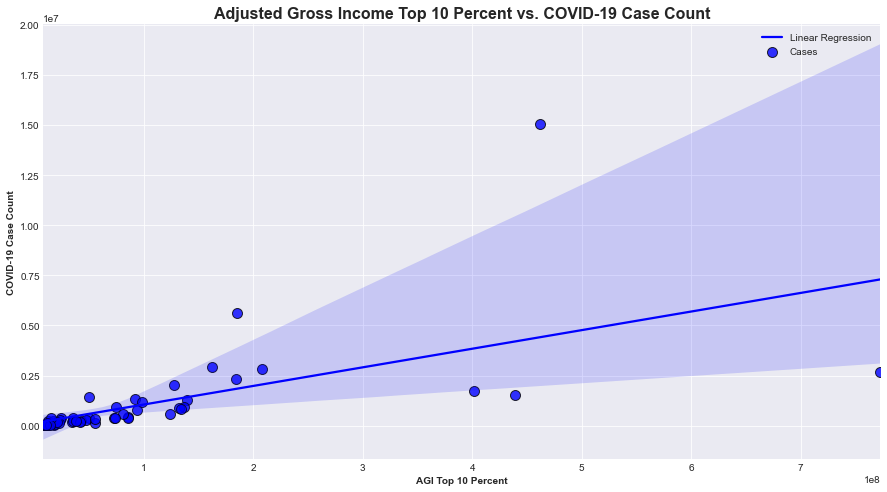

In [24]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'AGI Top 10 Percent', y = 'cases', data = COVIDAGI, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Adjusted Gross Income Top 10 Percent vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('AGI Top 10 Percent', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [25]:
model4 = sm.OLS(COVIDAGI['cases'], COVIDAGI['AGI Top 10 Percent']).fit()
model4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.456
Model:                            OLS   Adj. R-squared (uncentered):              0.445
Method:                 Least Squares   F-statistic:                              41.93
Date:                Wed, 10 Jun 2020   Prob (F-statistic):                    3.97e-08
Time:                        00:26:49   Log-Likelihood:                         -807.44
No. Observations:                  51   AIC:                                      1617.
Df Residuals:                      50   BIC:                                      1619.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AGI Top 10 Percent     0.0097      0.001      6.475      0.000       0.007       0.013
==============================================================================
Omnibus:                       70.716   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              973.913
Skew:                           3.442   Prob(JB):                    3.29e-212
Kurtosis:                      23.271   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

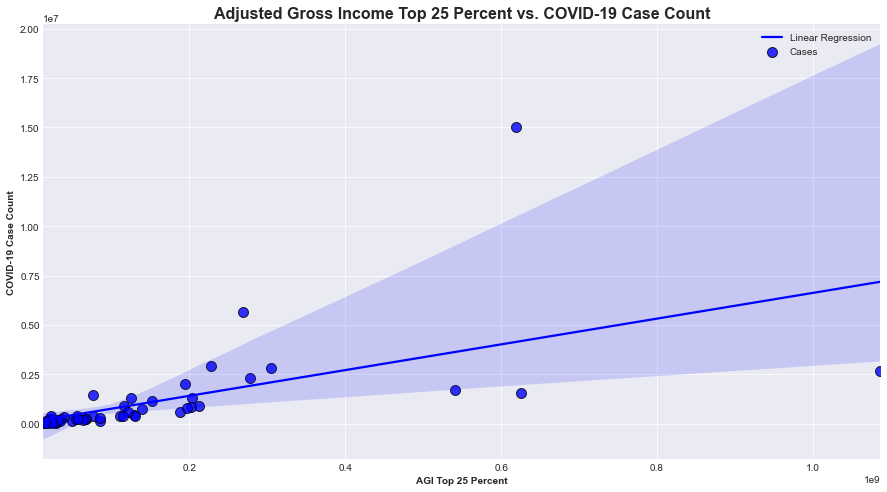

In [26]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'AGI Top 25 Percent', y = 'cases', data = COVIDAGI, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Adjusted Gross Income Top 25 Percent vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('AGI Top 25 Percent', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [27]:
model5 = sm.OLS(COVIDAGI['cases'], COVIDAGI['AGI Top 25 Percent']).fit()
model5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.444
Model:                            OLS   Adj. R-squared (uncentered):              0.432
Method:                 Least Squares   F-statistic:                              39.86
Date:                Wed, 10 Jun 2020   Prob (F-statistic):                    7.11e-08
Time:                        00:26:49   Log-Likelihood:                         -808.02
No. Observations:                  51   AIC:                                      1618.
Df Residuals:                      50   BIC:                                      1620.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AGI Top 25 Percent     0.0068      0.001      6.314      0.000       0.005       0.009
==============================================================================
Omnibus:                       74.332   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1103.324
Skew:                           3.691   Prob(JB):                    2.61e-240
Kurtosis:                      24.557   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

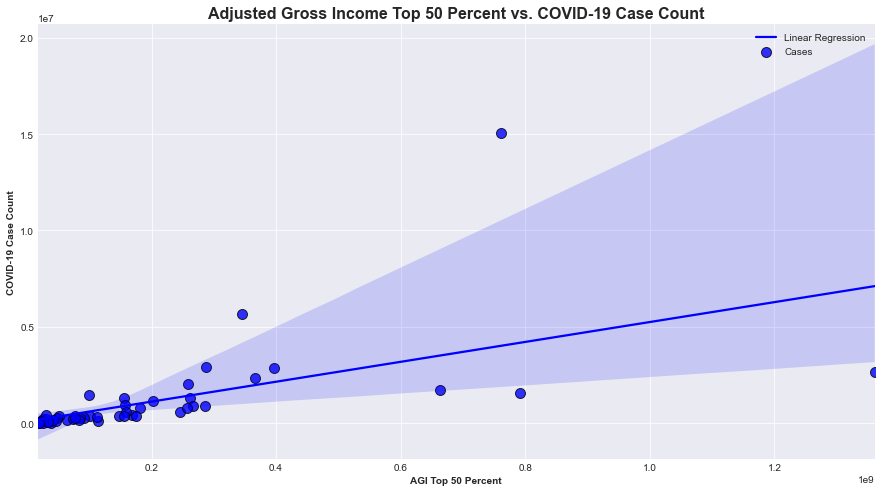

In [28]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'AGI Top 50 Percent', y = 'cases', data = COVIDAGI, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Adjusted Gross Income Top 50 Percent vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('AGI Top 50 Percent', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [29]:
model6 = sm.OLS(COVIDAGI['cases'], COVIDAGI['AGI Top 50 Percent']).fit()
model6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.438
Model:                            OLS   Adj. R-squared (uncentered):              0.427
Method:                 Least Squares   F-statistic:                              39.02
Date:                Wed, 10 Jun 2020   Prob (F-statistic):                    9.06e-08
Time:                        00:26:50   Log-Likelihood:                         -808.26
No. Observations:                  51   AIC:                                      1619.
Df Residuals:                      50   BIC:                                      1620.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AGI Top 50 Percent     0.0053      0.001      6.246      0.000       0.004       0.007
==============================================================================
Omnibus:                       76.326   Durbin-Watson:                   2.060
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1179.927
Skew:                           3.833   Prob(JB):                    6.05e-257
Kurtosis:                      25.282   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

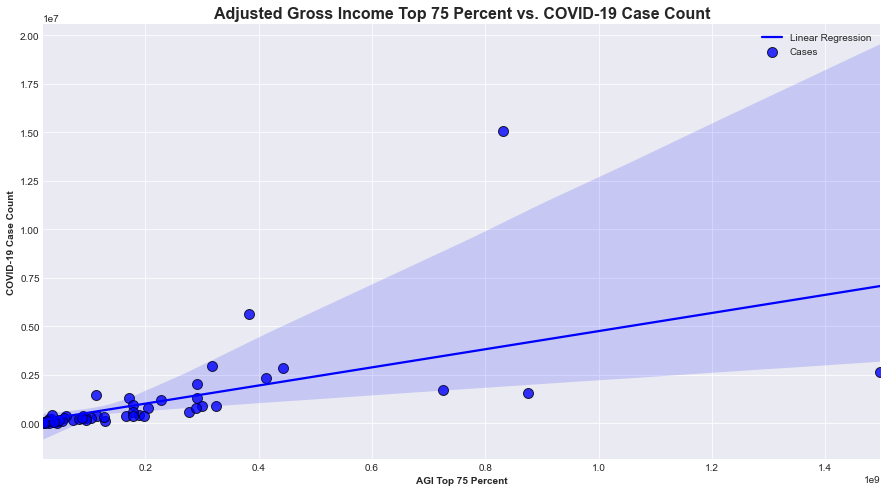

In [30]:
fig = plt.figure(figsize = (15,8))

sns.regplot(x = 'AGI Top 75 Percent', y = 'cases', data = COVIDAGI, color = 'b', scatter_kws = {'linewidths':1, 'edgecolor':'k', 's':100})

plt.title('Adjusted Gross Income Top 75 Percent vs. COVID-19 Case Count', fontsize = 16, fontweight = 'bold')
plt.xlabel('AGI Top 75 Percent', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Linear Regression', 'Cases'])

plt.show();

In [31]:
model7 = sm.OLS(COVIDAGI['cases'], COVIDAGI['AGI Top 75 Percent']).fit()
model7.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  cases   R-squared (uncentered):                   0.436
Model:                            OLS   Adj. R-squared (uncentered):              0.424
Method:                 Least Squares   F-statistic:                              38.60
Date:                Wed, 10 Jun 2020   Prob (F-statistic):                    1.02e-07
Time:                        00:26:50   Log-Likelihood:                         -808.38
No. Observations:                  51   AIC:                                      1619.
Df Residuals:                      50   BIC:                                      1621.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
AGI Top 75 Percent     0.0048      0.001      6.213      0.000       0.003       0.006
==============================================================================
Omnibus:                       77.155   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1212.146
Skew:                           3.894   Prob(JB):                    6.11e-264
Kurtosis:                      25.578   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

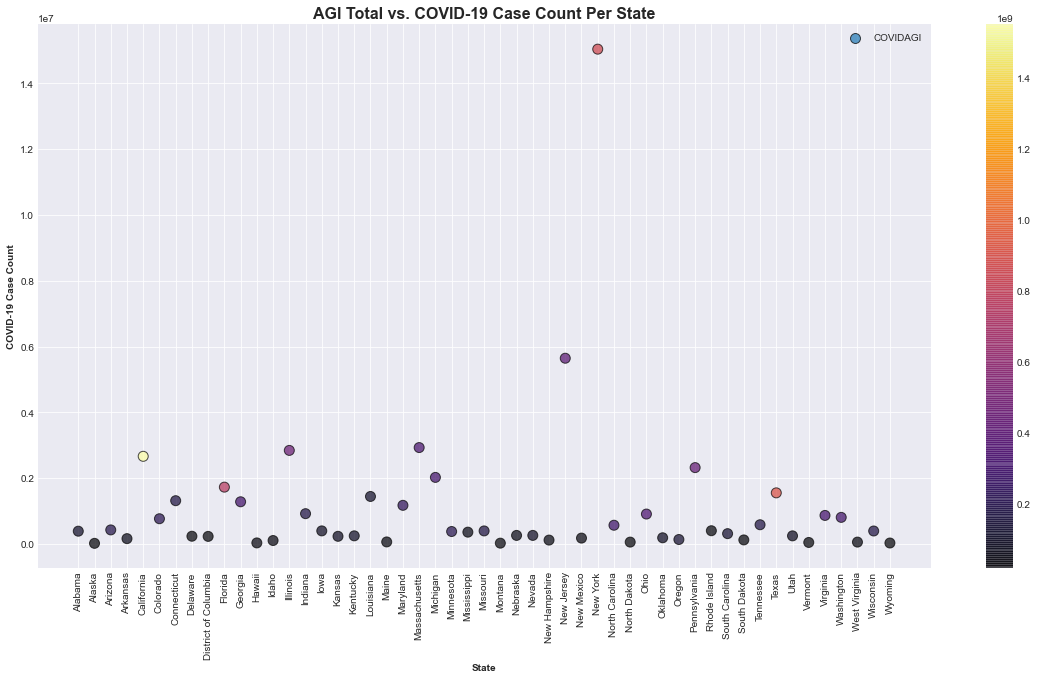

In [32]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = COVIDAGI['State'] 
y = COVIDAGI['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = COVIDAGI['AGI Total'], cmap = 'inferno')
plt.title('AGI Total vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['COVIDAGI'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

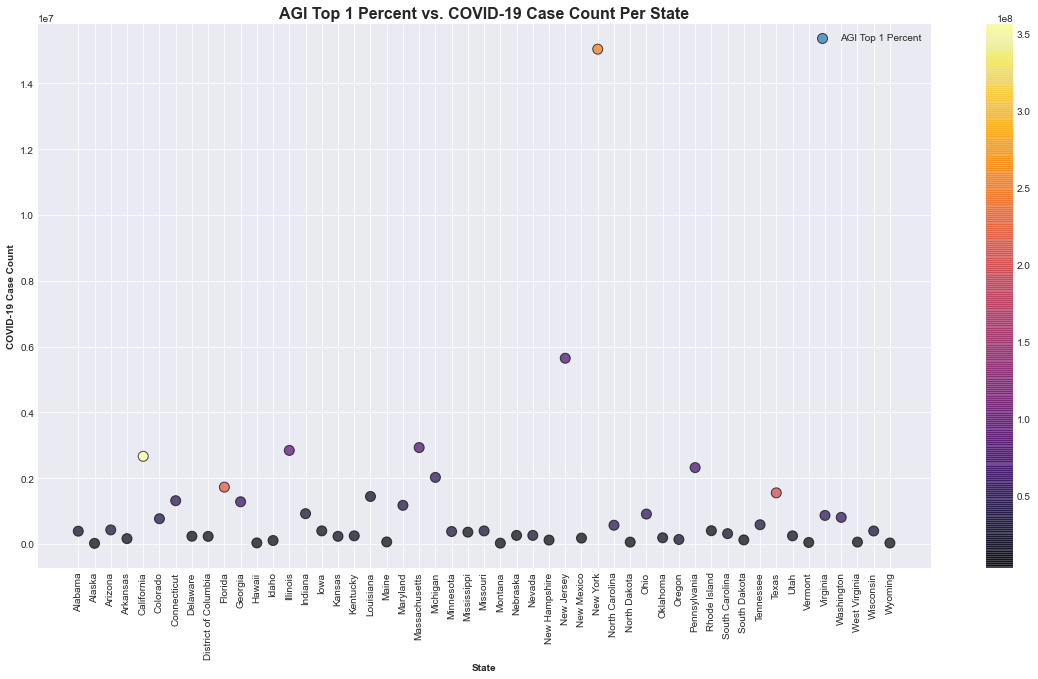

In [33]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = COVIDAGI['State'] 
y = COVIDAGI['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = COVIDAGI['AGI Top 1 Percent'], cmap = 'inferno')
plt.title('AGI Top 1 Percent vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['AGI Top 1 Percent'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

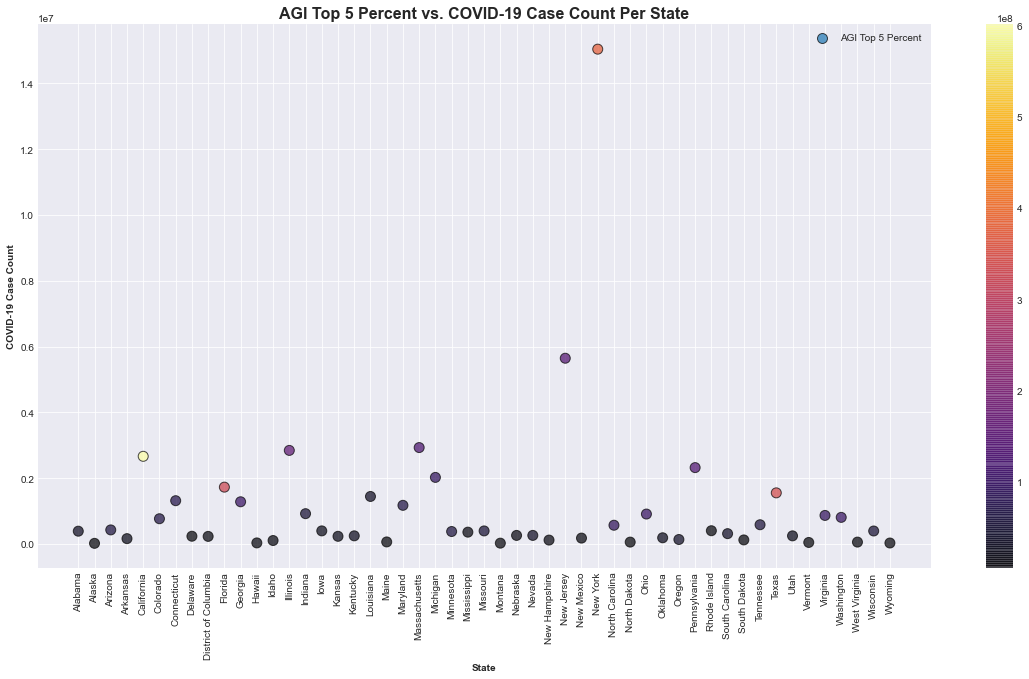

In [34]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = COVIDAGI['State'] 
y = COVIDAGI['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = COVIDAGI['AGI Top 5 Percent'], cmap = 'inferno')
plt.title('AGI Top 5 Percent vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['AGI Top 5 Percent'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

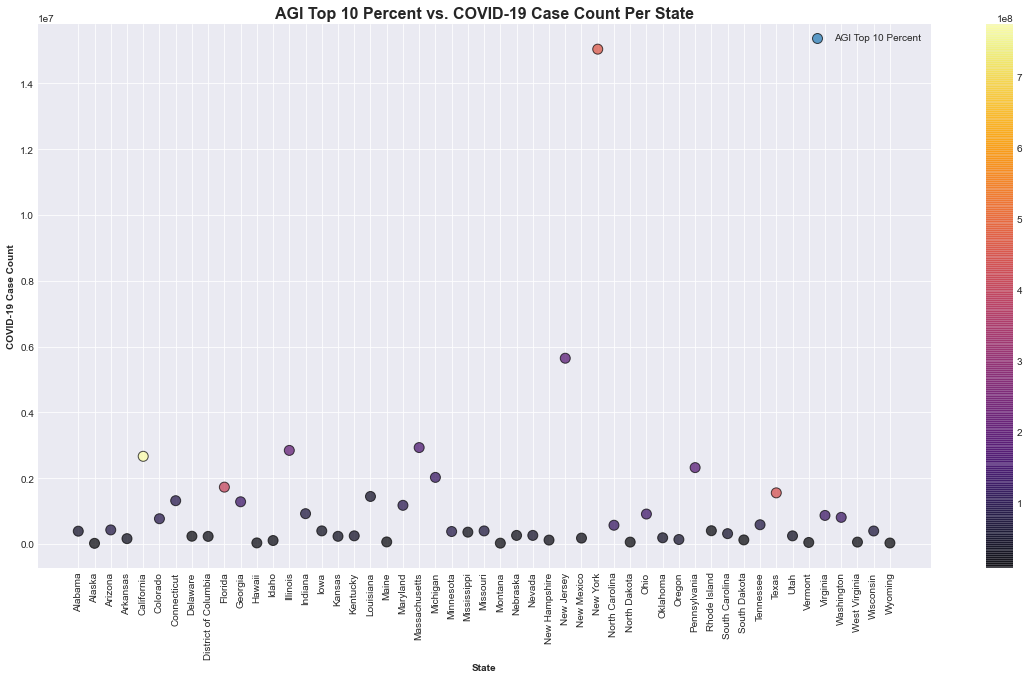

In [35]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = COVIDAGI['State'] 
y = COVIDAGI['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = COVIDAGI['AGI Top 10 Percent'], cmap = 'inferno')
plt.title('AGI Top 10 Percent vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['AGI Top 10 Percent'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

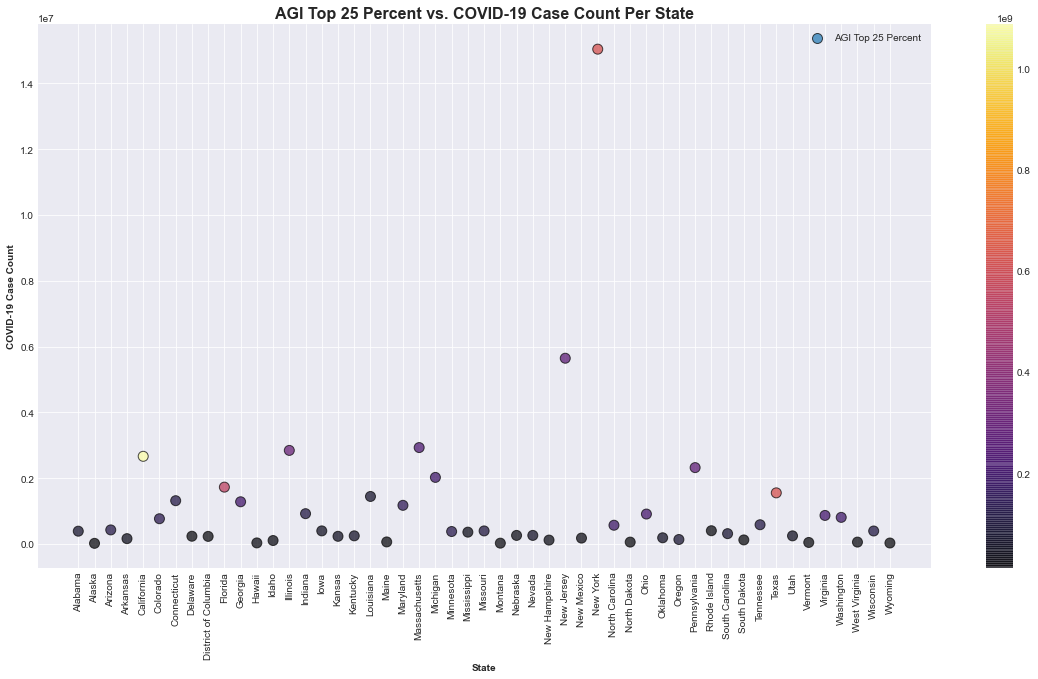

In [36]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = COVIDAGI['State'] 
y = COVIDAGI['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = COVIDAGI['AGI Top 25 Percent'], cmap = 'inferno')
plt.title('AGI Top 25 Percent vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['AGI Top 25 Percent'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

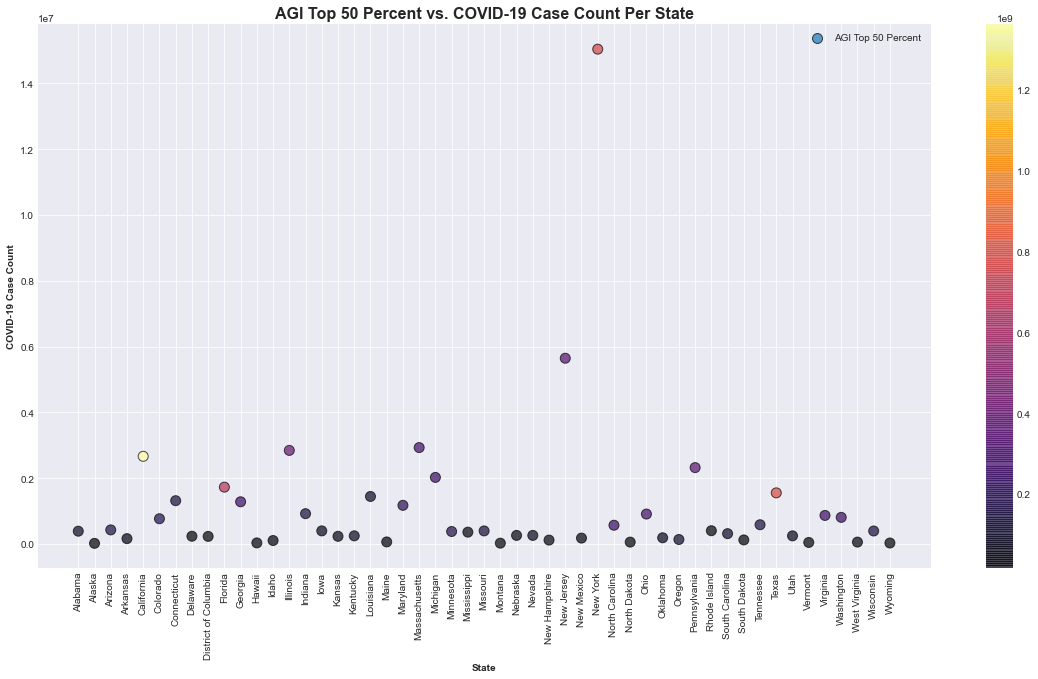

In [37]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = COVIDAGI['State'] 
y = COVIDAGI['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = COVIDAGI['AGI Top 50 Percent'], cmap = 'inferno')
plt.title('AGI Top 50 Percent vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['AGI Top 50 Percent'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

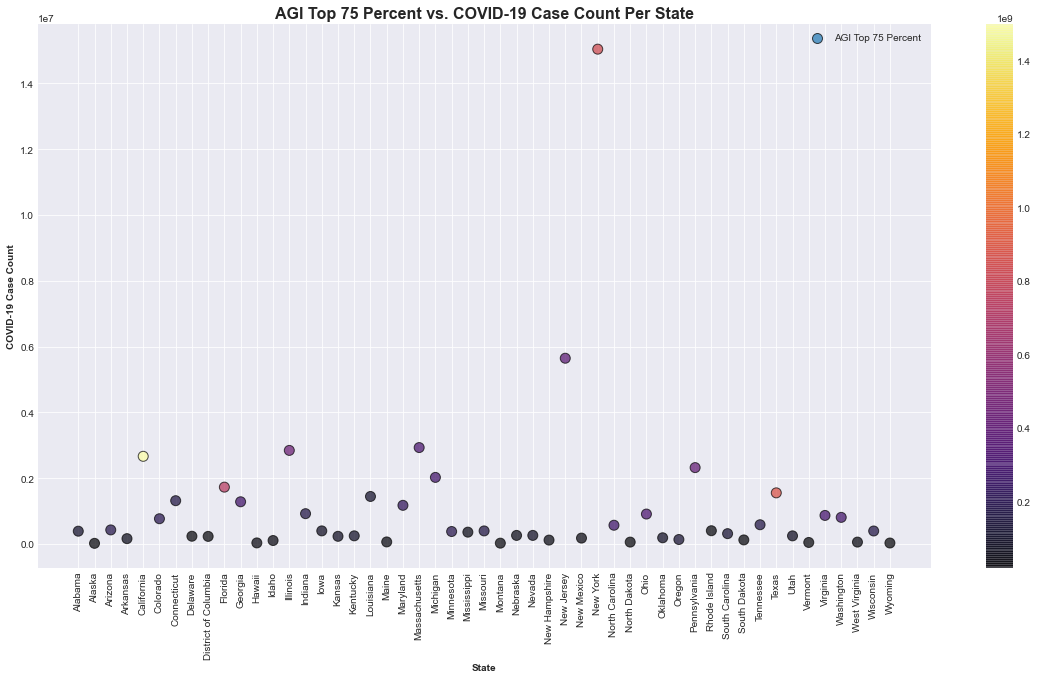

In [38]:
plt.style.use('seaborn-darkgrid')
fig = plt.figure(figsize = (20,10))

x = COVIDAGI['State'] 
y = COVIDAGI['cases']

plt.scatter(x, y, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, c = COVIDAGI['AGI Top 75 Percent'], cmap = 'inferno')
plt.title('AGI Top 75 Percent vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['AGI Top 75 Percent'])

plt.xticks(rotation = 90)

plt.colorbar()
plt.show();

In [3]:
test_len = int(0.25 * len(COVIDAGI))
train_len = len(COVIDAGI) - test_len
print('Train Set Len: ' + str(train_len))
print('Test Set Len: ' + str(test_len))

train = COVIDAGI[:train_len]
test = COVIDAGI[train_len:]
print('Train Set Shape: ' + str(train.shape))
print('Test Set Shape: ' + str(test.shape))

Train Set Len: 39
Test Set Len: 12
Train Set Shape: (39, 10)
Test Set Shape: (12, 10)


In [4]:
features_list = ['AGI Total']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBClassifier()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions = XGBmodel.predict(X_train_scaled)
test_predictions = XGBmodel.predict(X_test_scaled)

MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 433216.9166666667
MSE Value: 371541475879.25
RMS Value: 609542.0214220263
R2 Score: -1.0207343791499985


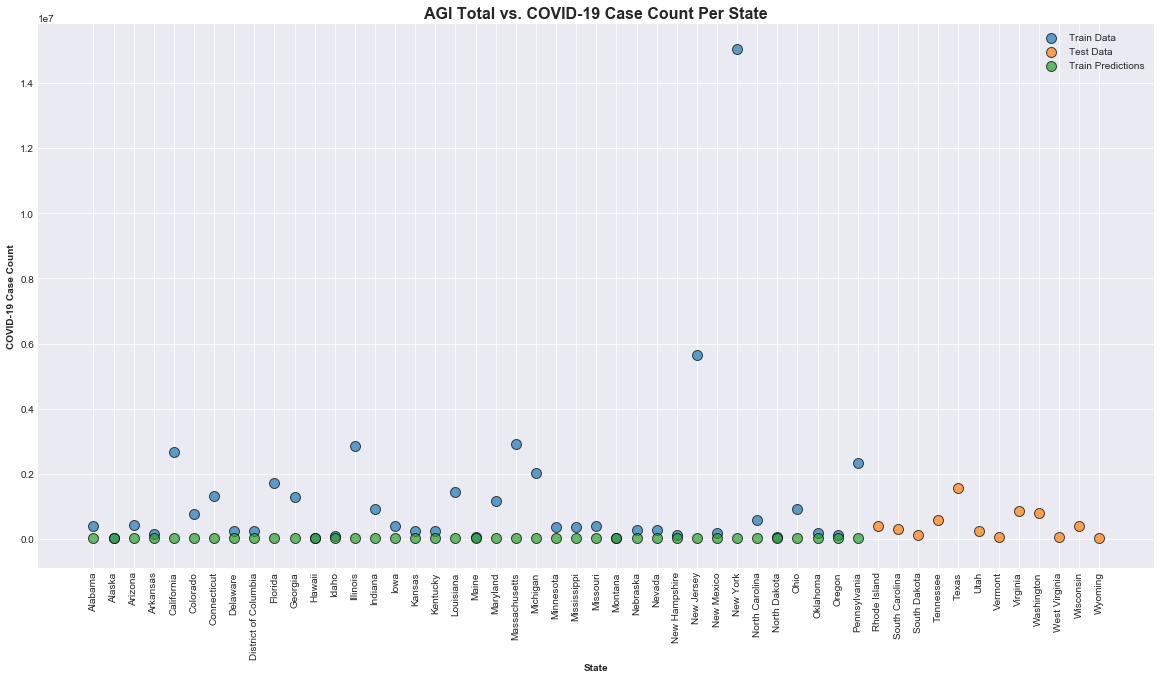

In [5]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('AGI Total vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

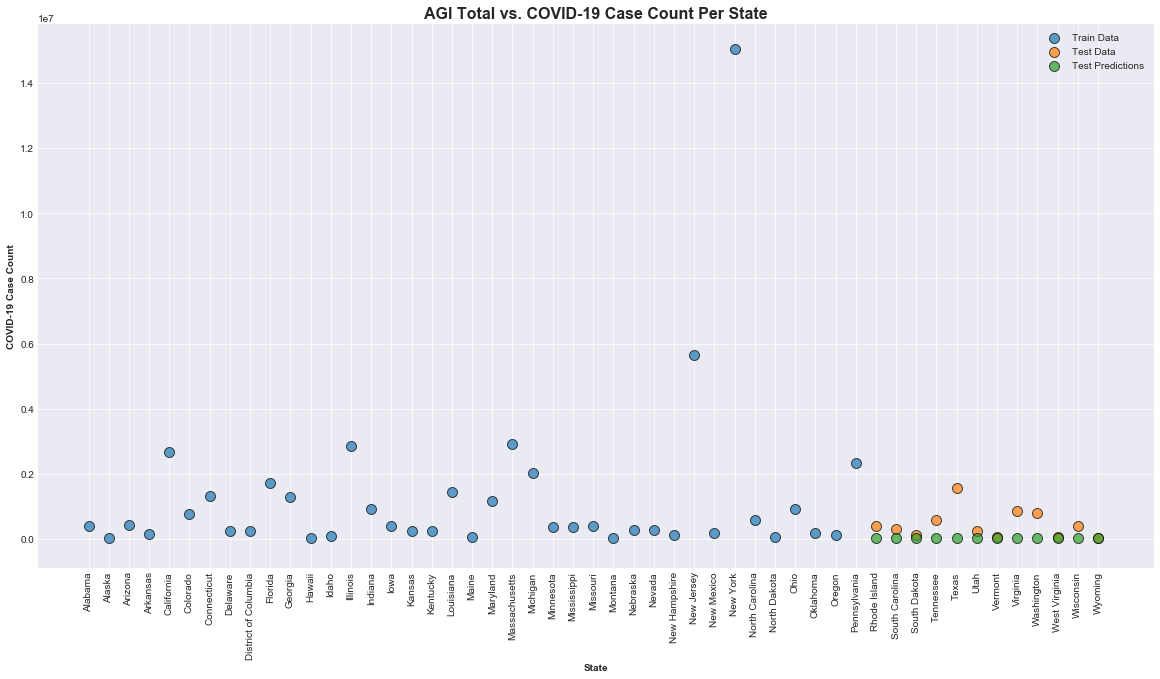

In [6]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('AGI Total vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [7]:
features_list = ['AGI Top 1 Percent']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBClassifier()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions = XGBmodel.predict(X_train_scaled)
test_predictions = XGBmodel.predict(X_test_scaled)

MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 433216.9166666667
MSE Value: 371541475879.25
RMS Value: 609542.0214220263
R2 Score: -1.0207343791499985


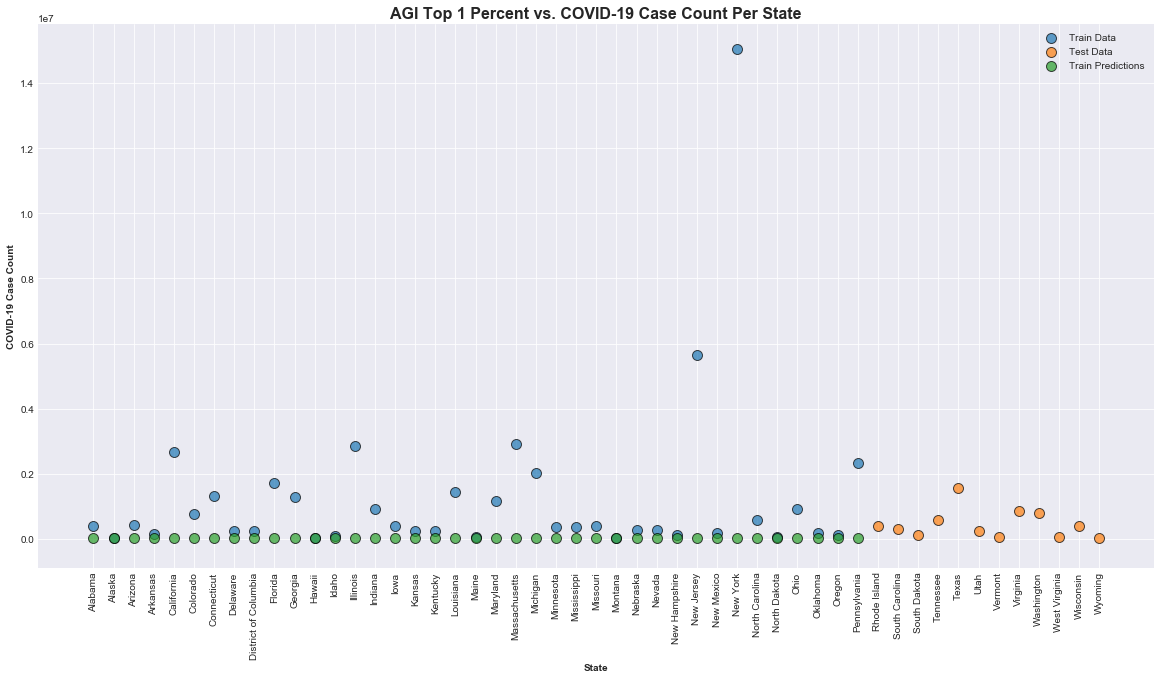

In [8]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('AGI Top 1 Percent vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

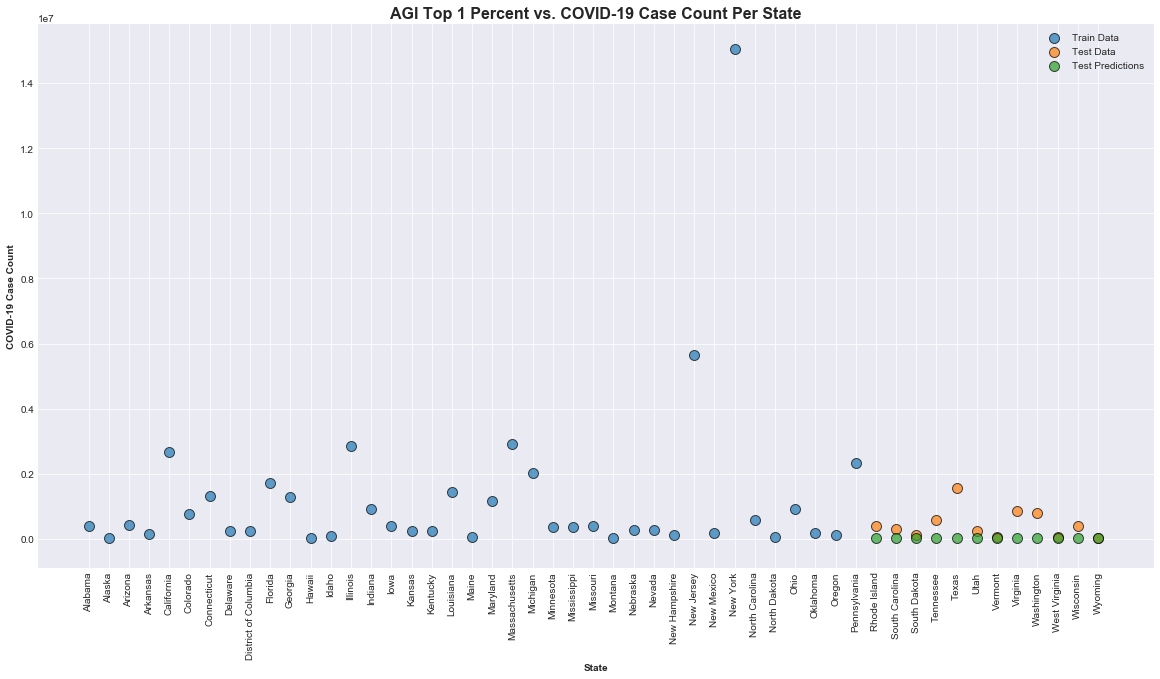

In [9]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('AGI Top 1 Percent vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [10]:
features_list = ['AGI Top 5 Percent']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBClassifier()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions = XGBmodel.predict(X_train_scaled)
test_predictions = XGBmodel.predict(X_test_scaled)

MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 433216.9166666667
MSE Value: 371541475879.25
RMS Value: 609542.0214220263
R2 Score: -1.0207343791499985


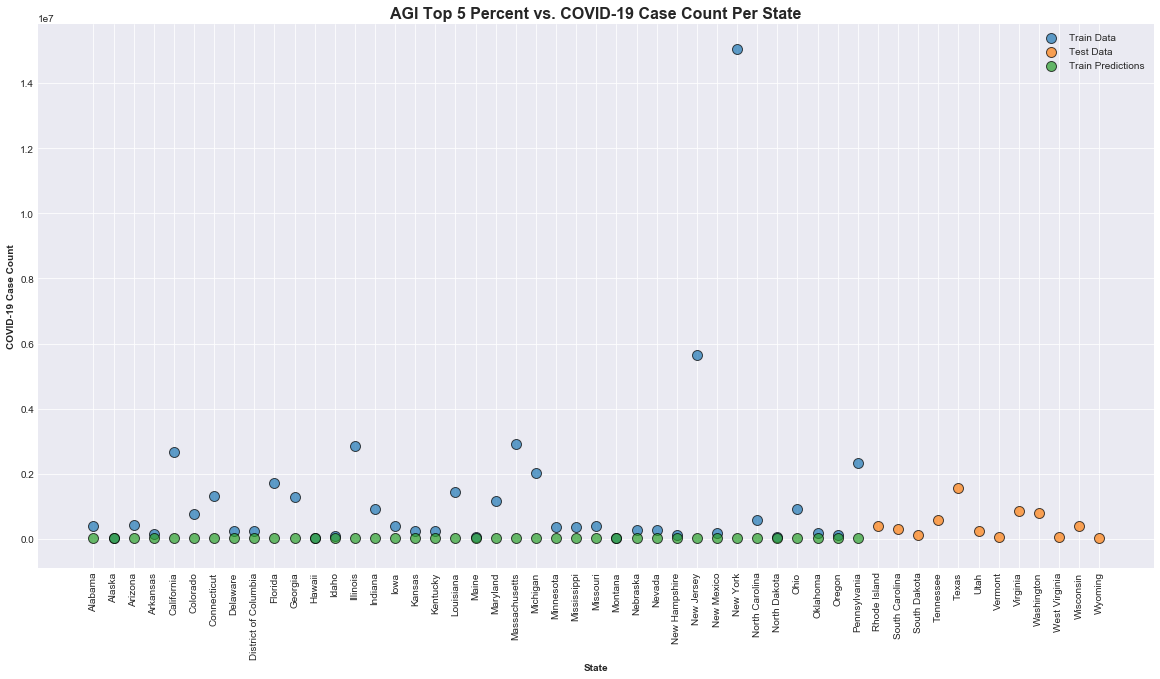

In [11]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('AGI Top 5 Percent vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

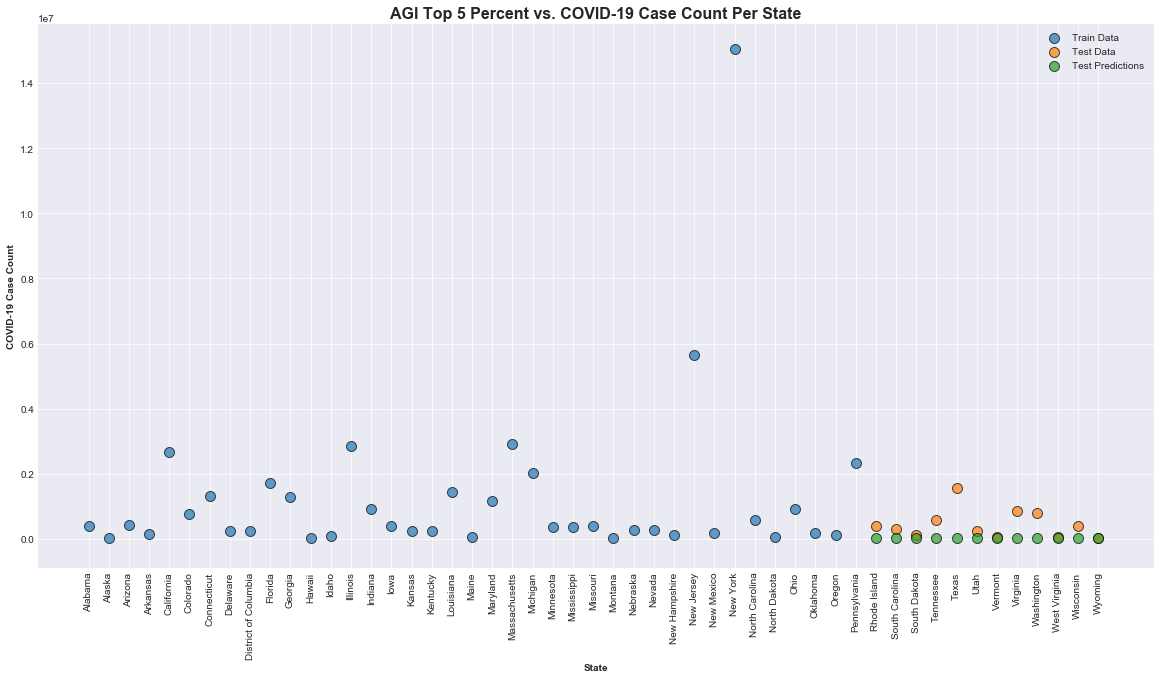

In [12]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('AGI Top 5 Percent vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [13]:
features_list = ['AGI Top 10 Percent']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBClassifier()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions = XGBmodel.predict(X_train_scaled)
test_predictions = XGBmodel.predict(X_test_scaled)


MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 433216.9166666667
MSE Value: 371541475879.25
RMS Value: 609542.0214220263
R2 Score: -1.0207343791499985


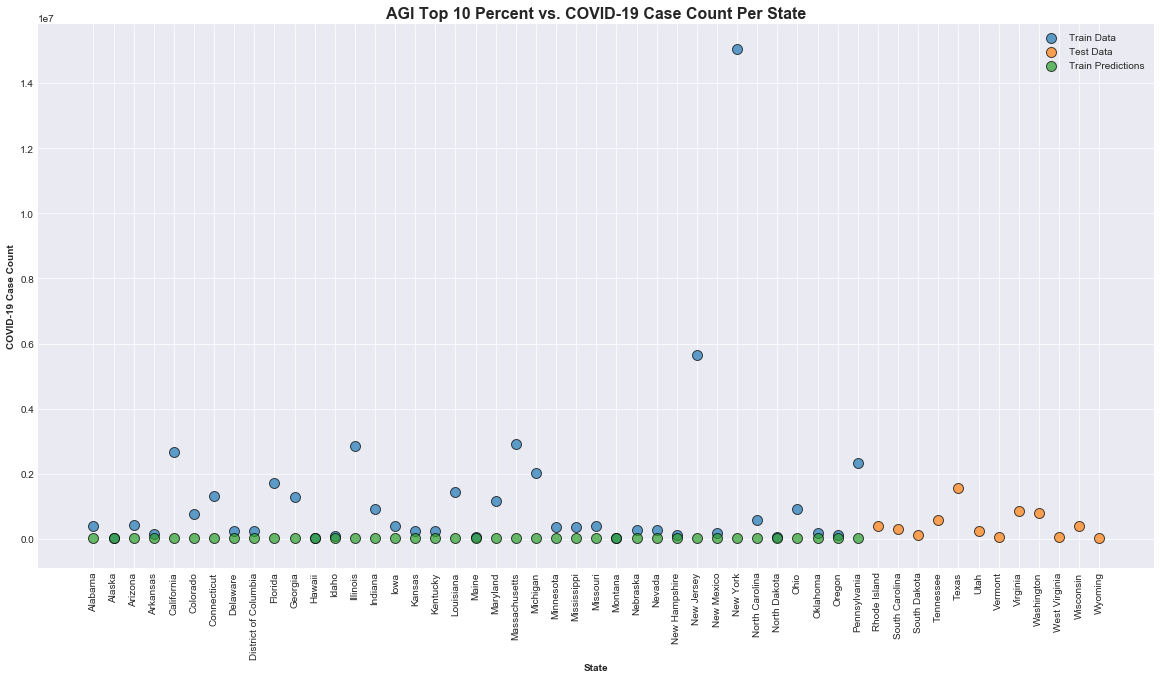

In [14]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('AGI Top 10 Percent vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

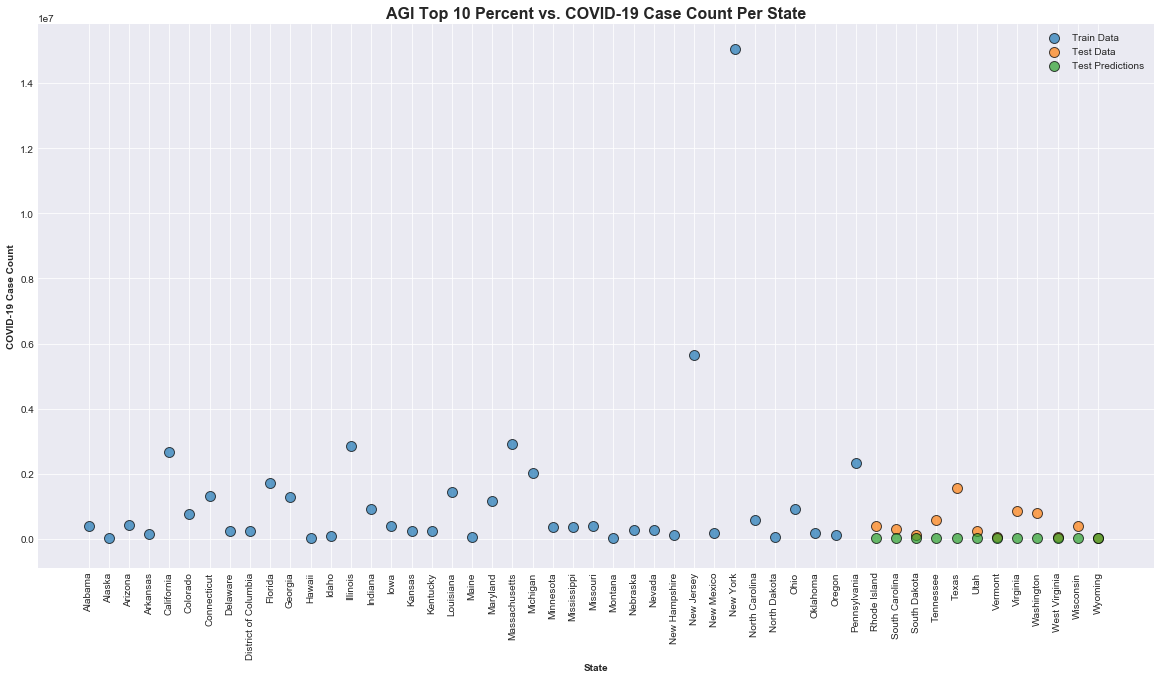

In [15]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('AGI Top 10 Percent vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [16]:
features_list = ['AGI Top 25 Percent']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBClassifier()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions = XGBmodel.predict(X_train_scaled)
test_predictions = XGBmodel.predict(X_test_scaled)

MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 433216.9166666667
MSE Value: 371541475879.25
RMS Value: 609542.0214220263
R2 Score: -1.0207343791499985


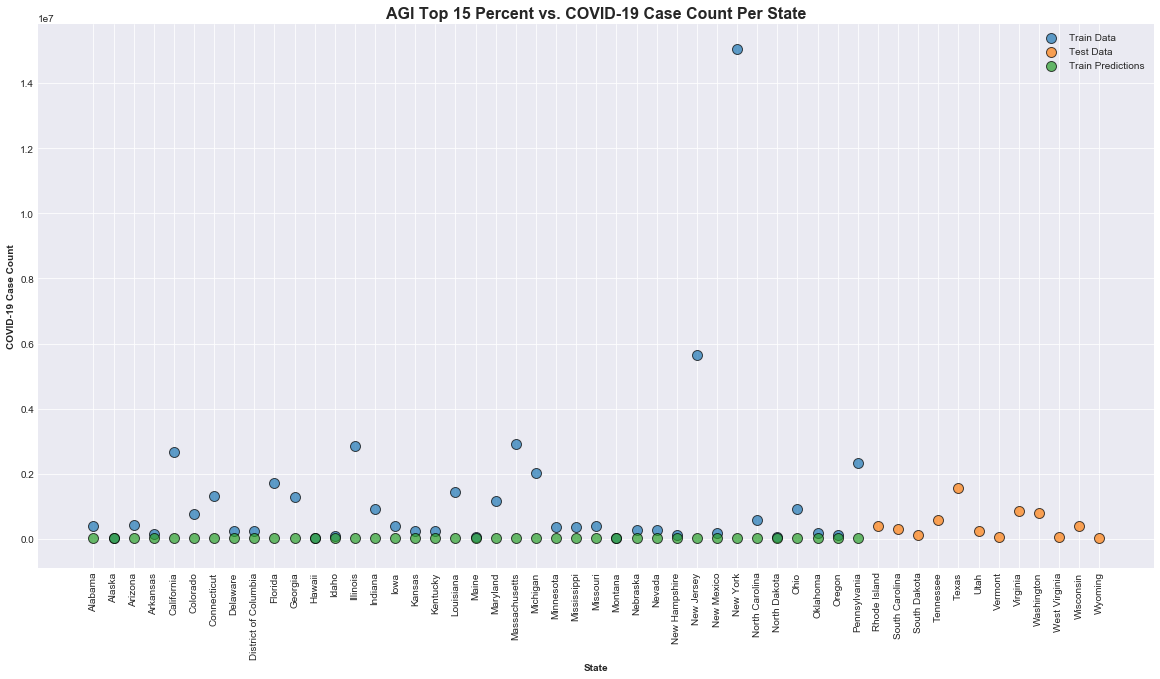

In [17]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('AGI Top 15 Percent vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

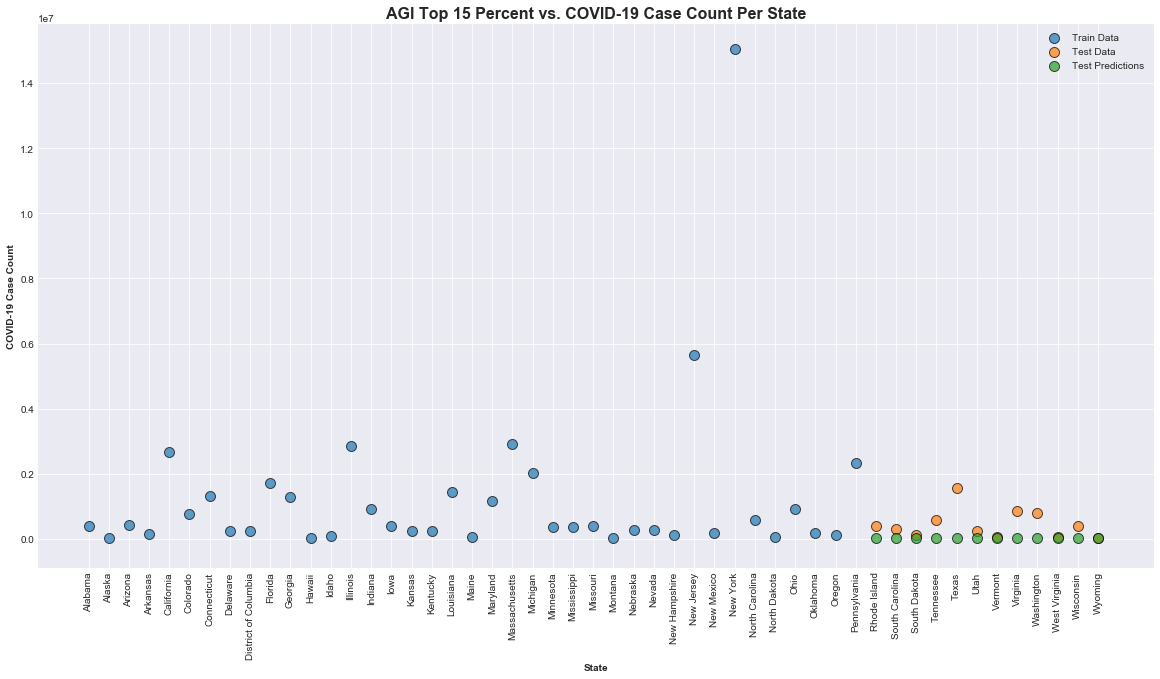

In [18]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('AGI Top 15 Percent vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [19]:
features_list = ['AGI Top 50 Percent']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBClassifier()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions = XGBmodel.predict(X_train_scaled)
test_predictions = XGBmodel.predict(X_test_scaled)

MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 433216.9166666667
MSE Value: 371541475879.25
RMS Value: 609542.0214220263
R2 Score: -1.0207343791499985


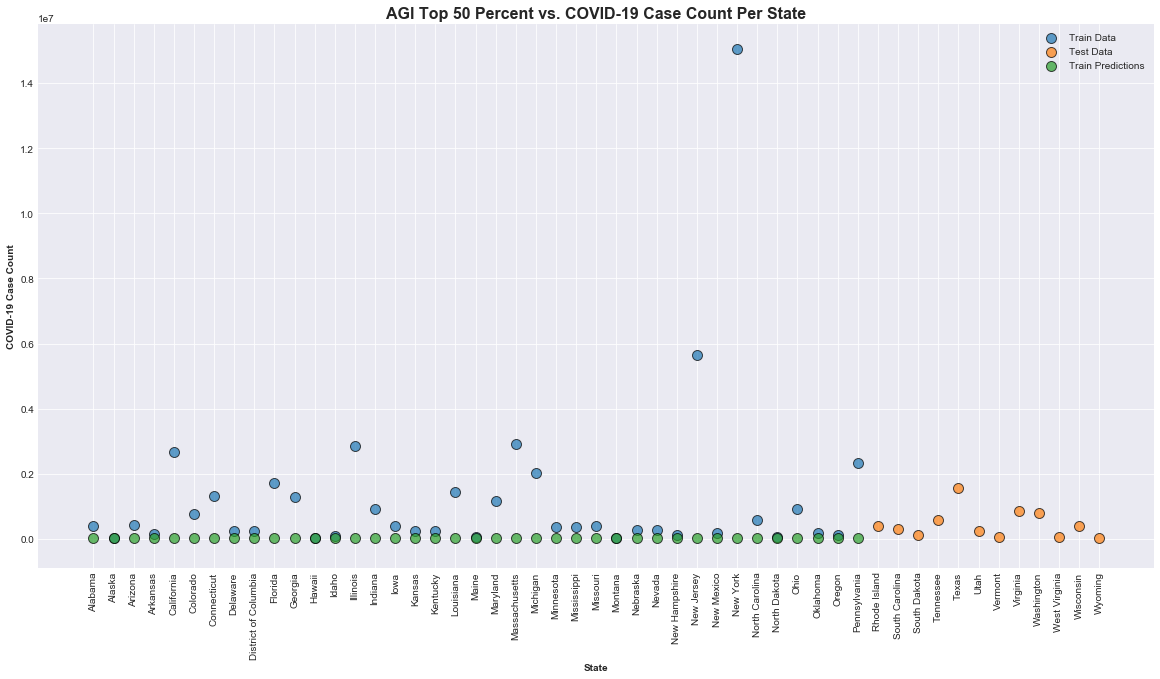

In [20]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('AGI Top 50 Percent vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

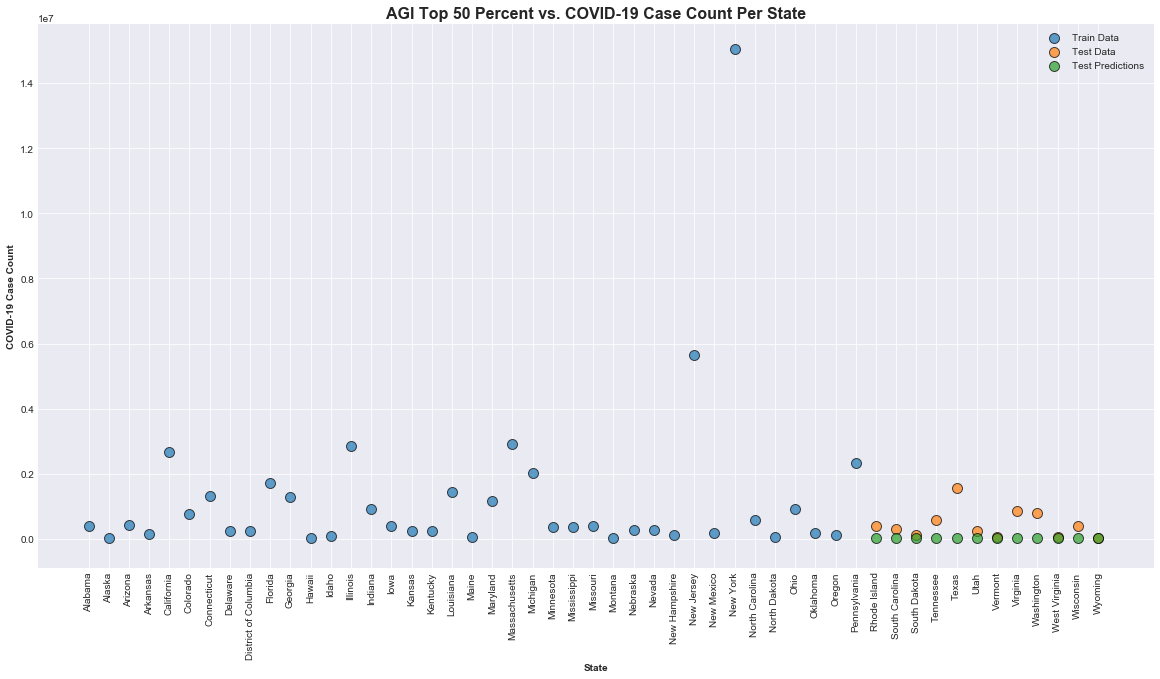

In [21]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('AGI Top 50 Percent vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [23]:
features_list = ['AGI Top 75 Percent']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(np.array(X_train).reshape(-1, 1))
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(np.array(X_test).reshape(-1, 1))

XGBmodel = XGBClassifier()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions = XGBmodel.predict(X_train_scaled)
test_predictions = XGBmodel.predict(X_test_scaled)

MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 433216.9166666667
MSE Value: 371541475879.25
RMS Value: 609542.0214220263
R2 Score: -1.0207343791499985


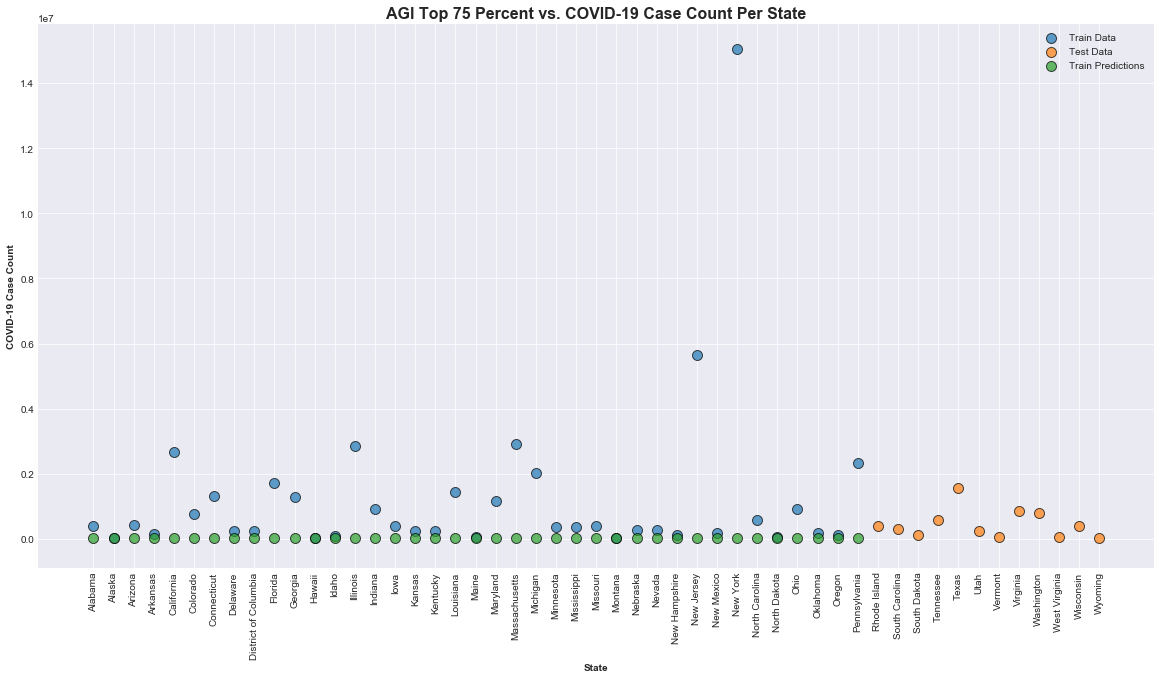

In [24]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('AGI Top 75 Percent vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

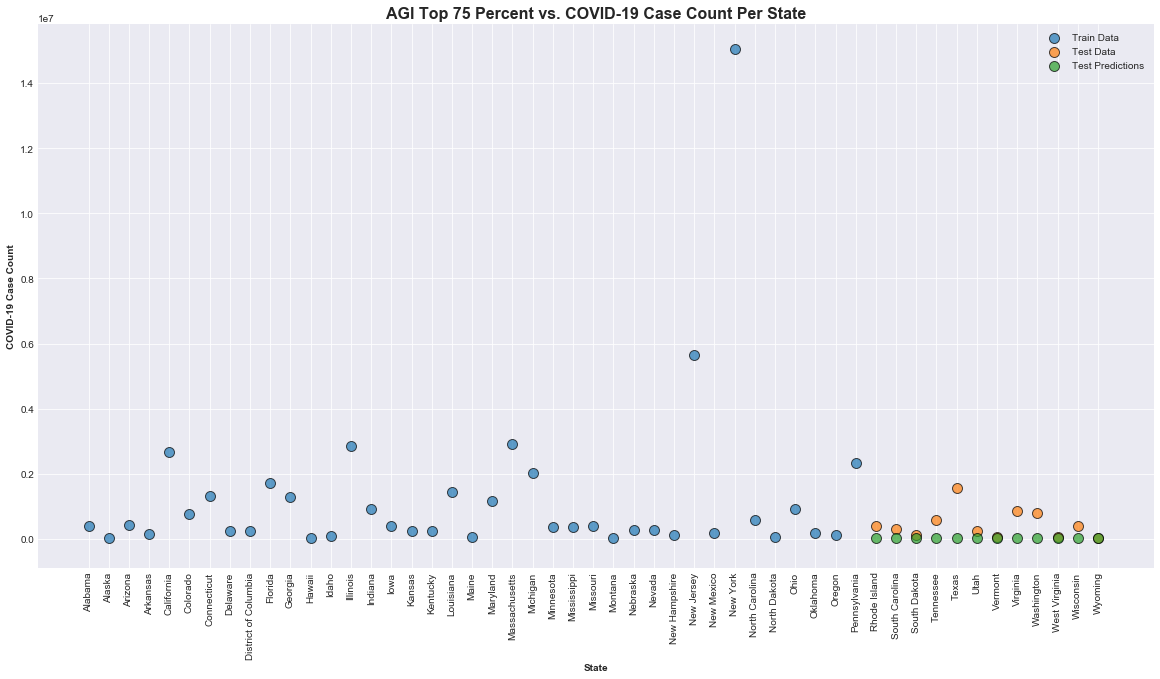

In [25]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('AGI Top 75 Percent vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();

In [26]:
features_list = ['AGI Top 1 Percent','AGI Top 5 Percent','AGI Top 10 Percent','AGI Top 25 Percent','AGI Top 50 Percent',
                 'AGI Top 75 Percent']
    
target = 'cases'

X_train = train[features_list]
y_train = train[target]
X_test = test[features_list]
y_test = test[target]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
X_test_scaled = scaler.transform(X_test)

XGBmodel = XGBClassifier()
XGBmodel.fit(X_train_scaled, y_train)

train_predictions = XGBmodel.predict(X_train_scaled)
test_predictions = XGBmodel.predict(X_test_scaled)

MAE = mean_absolute_error(y_test, test_predictions)
MSE = mean_squared_error(y_test, test_predictions)
RMS = sqrt(mean_squared_error(y_test, test_predictions))
R2Score = r2_score(y_test, test_predictions)

print('MAE Value:', MAE)
print('MSE Value:', MSE)
print('RMS Value:', RMS)
print('R2 Score:', R2Score)

MAE Value: 433216.9166666667
MSE Value: 371541475879.25
RMS Value: 609542.0214220263
R2 Score: -1.0207343791499985


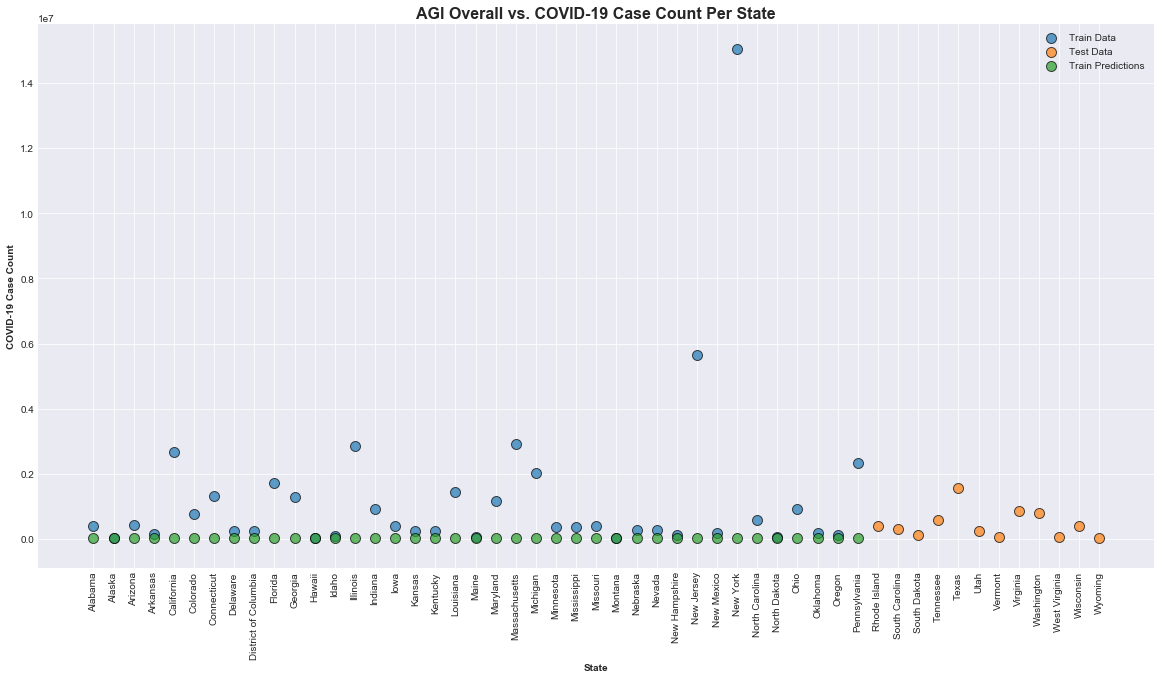

In [27]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = train['State'], y = train_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('AGI Overall vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Train Predictions'])

plt.xticks(rotation = 90)
plt.show();

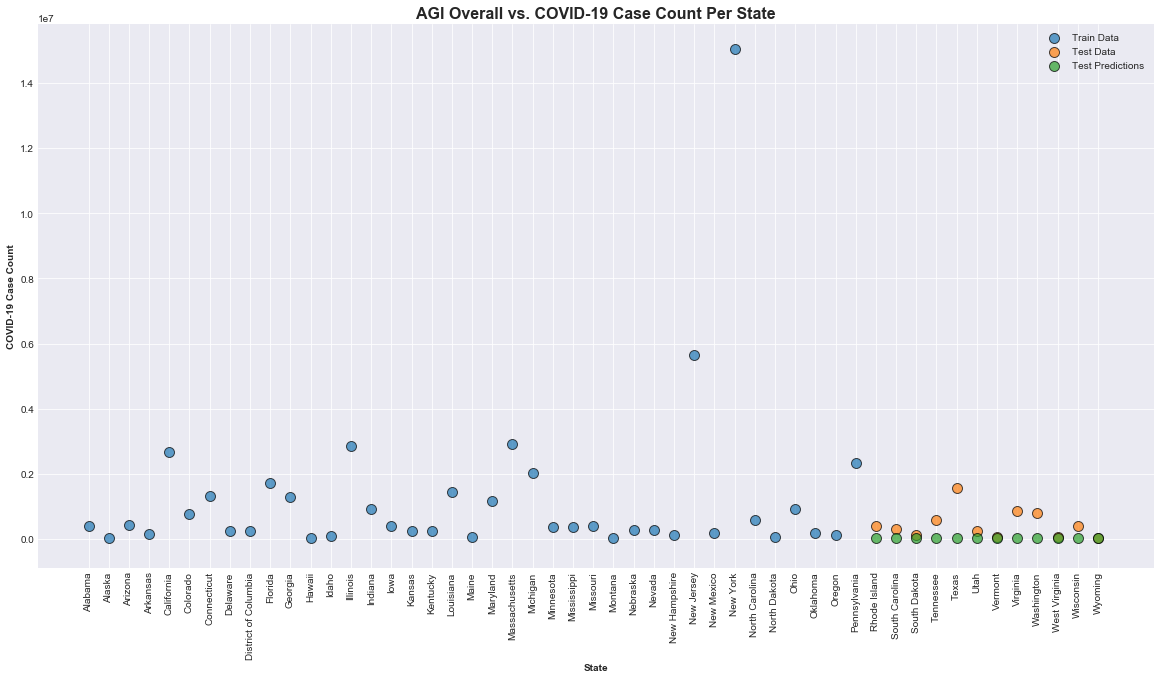

In [28]:
rcParams['figure.figsize'] = 20, 10

plt.figure()

plt.scatter(x = train['State'], y = train['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test['cases'], linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.scatter(x = test['State'], y = test_predictions, linewidths = 1, alpha = 0.7, edgecolor = 'k', s = 100, cmap = 'inferno')
plt.title('AGI Overall vs. COVID-19 Case Count Per State', fontsize = 16, fontweight = 'bold')
plt.xlabel('State', fontsize = 10, fontweight = 'bold')
plt.ylabel('COVID-19 Case Count', fontsize = 10, fontweight = 'bold')

plt.legend(['Train Data', 'Test Data', 'Test Predictions'])

plt.xticks(rotation = 90)
plt.show();